# Cluster annotation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scip_workflows.common import *

In [62]:
import anndata
import scanpy
from matplotlib.patches import ConnectionStyle
from sklearn.feature_selection import mutual_info_classif
import warnings

In [27]:
try:
    adata = snakemake.input[0]
    output = snakemake.output[0]
except NameError:
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/cd7/800/scip/150920221347/")
    adata = data_dir / "adata_0.h5ad"
    output = data_dir / "figures" / "cluster_annotation.png"

In [20]:
def map_names(a):
    return {
        "feat_combined_sum_DAPI": "DAPI",
        "feat_combined_sum_EGFP": "CD45",
        "feat_combined_sum_RPe": "Siglec 8",
        "feat_combined_sum_APC": "CD15"
    }[a]

markers = [col for col in adata.var_names if col.startswith(tuple("feat_combined_sum_%s" % m for m in ("EGFP", "RPe", "APC", "DAPI")))]

In [29]:
adata = anndata.read_h5ad(adata)

/srv/scratch/maximl/mambaforge/envs/scip/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<AxesSubplot:title={'center':'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

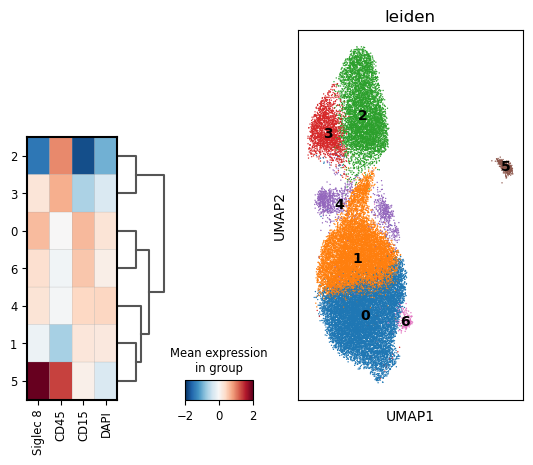

In [21]:
fig, axes = plt.subplots(1, 2)
ax = scanpy.pl.matrixplot(adata, markers, groupby='leiden', dendrogram=True, vmin=-2, vmax=2, cmap='RdBu_r', ax=axes[0], show=False)
ax["mainplot_ax"].set_xticklabels(map(lambda a: map_names(a.get_text()), ax["mainplot_ax"].get_xticklabels()))
scanpy.pl.umap(adata, color="leiden", legend_loc='on data', ax=axes[1], show=False)

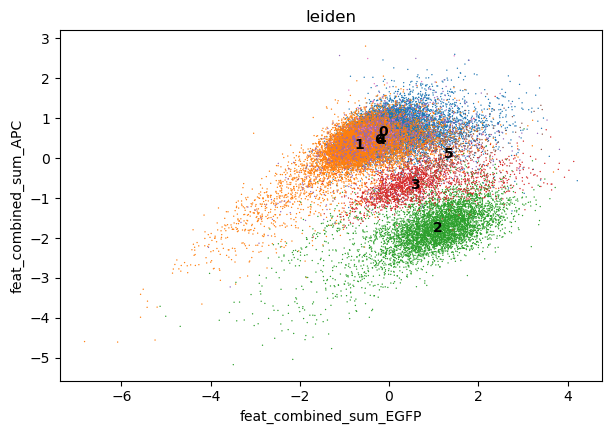

In [23]:
scanpy.pl.scatter(adata, x="feat_combined_sum_EGFP", y="feat_combined_sum_APC", color="leiden", legend_loc="on data")

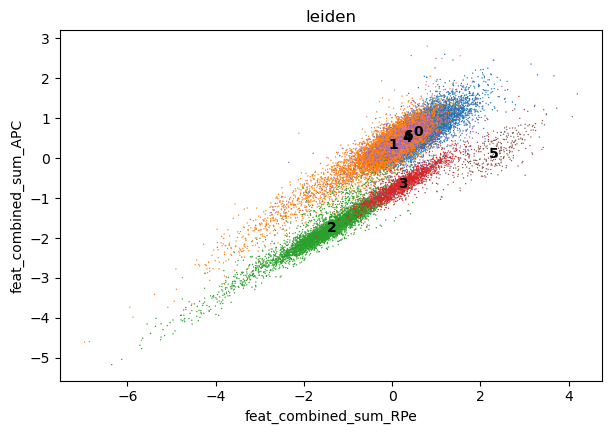

In [24]:
scanpy.pl.scatter(adata, x="feat_combined_sum_RPe", y="feat_combined_sum_APC", color="leiden", legend_loc="on data")

In [31]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    '0': 'neutrophils',
    '1': 'neutrophils',
    '4': 'neutrophils',
    '6': 'neutrophils',
    '5': 'eosinophils',
    '3': 'monocytes',
    '2': 'lymphocytes'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

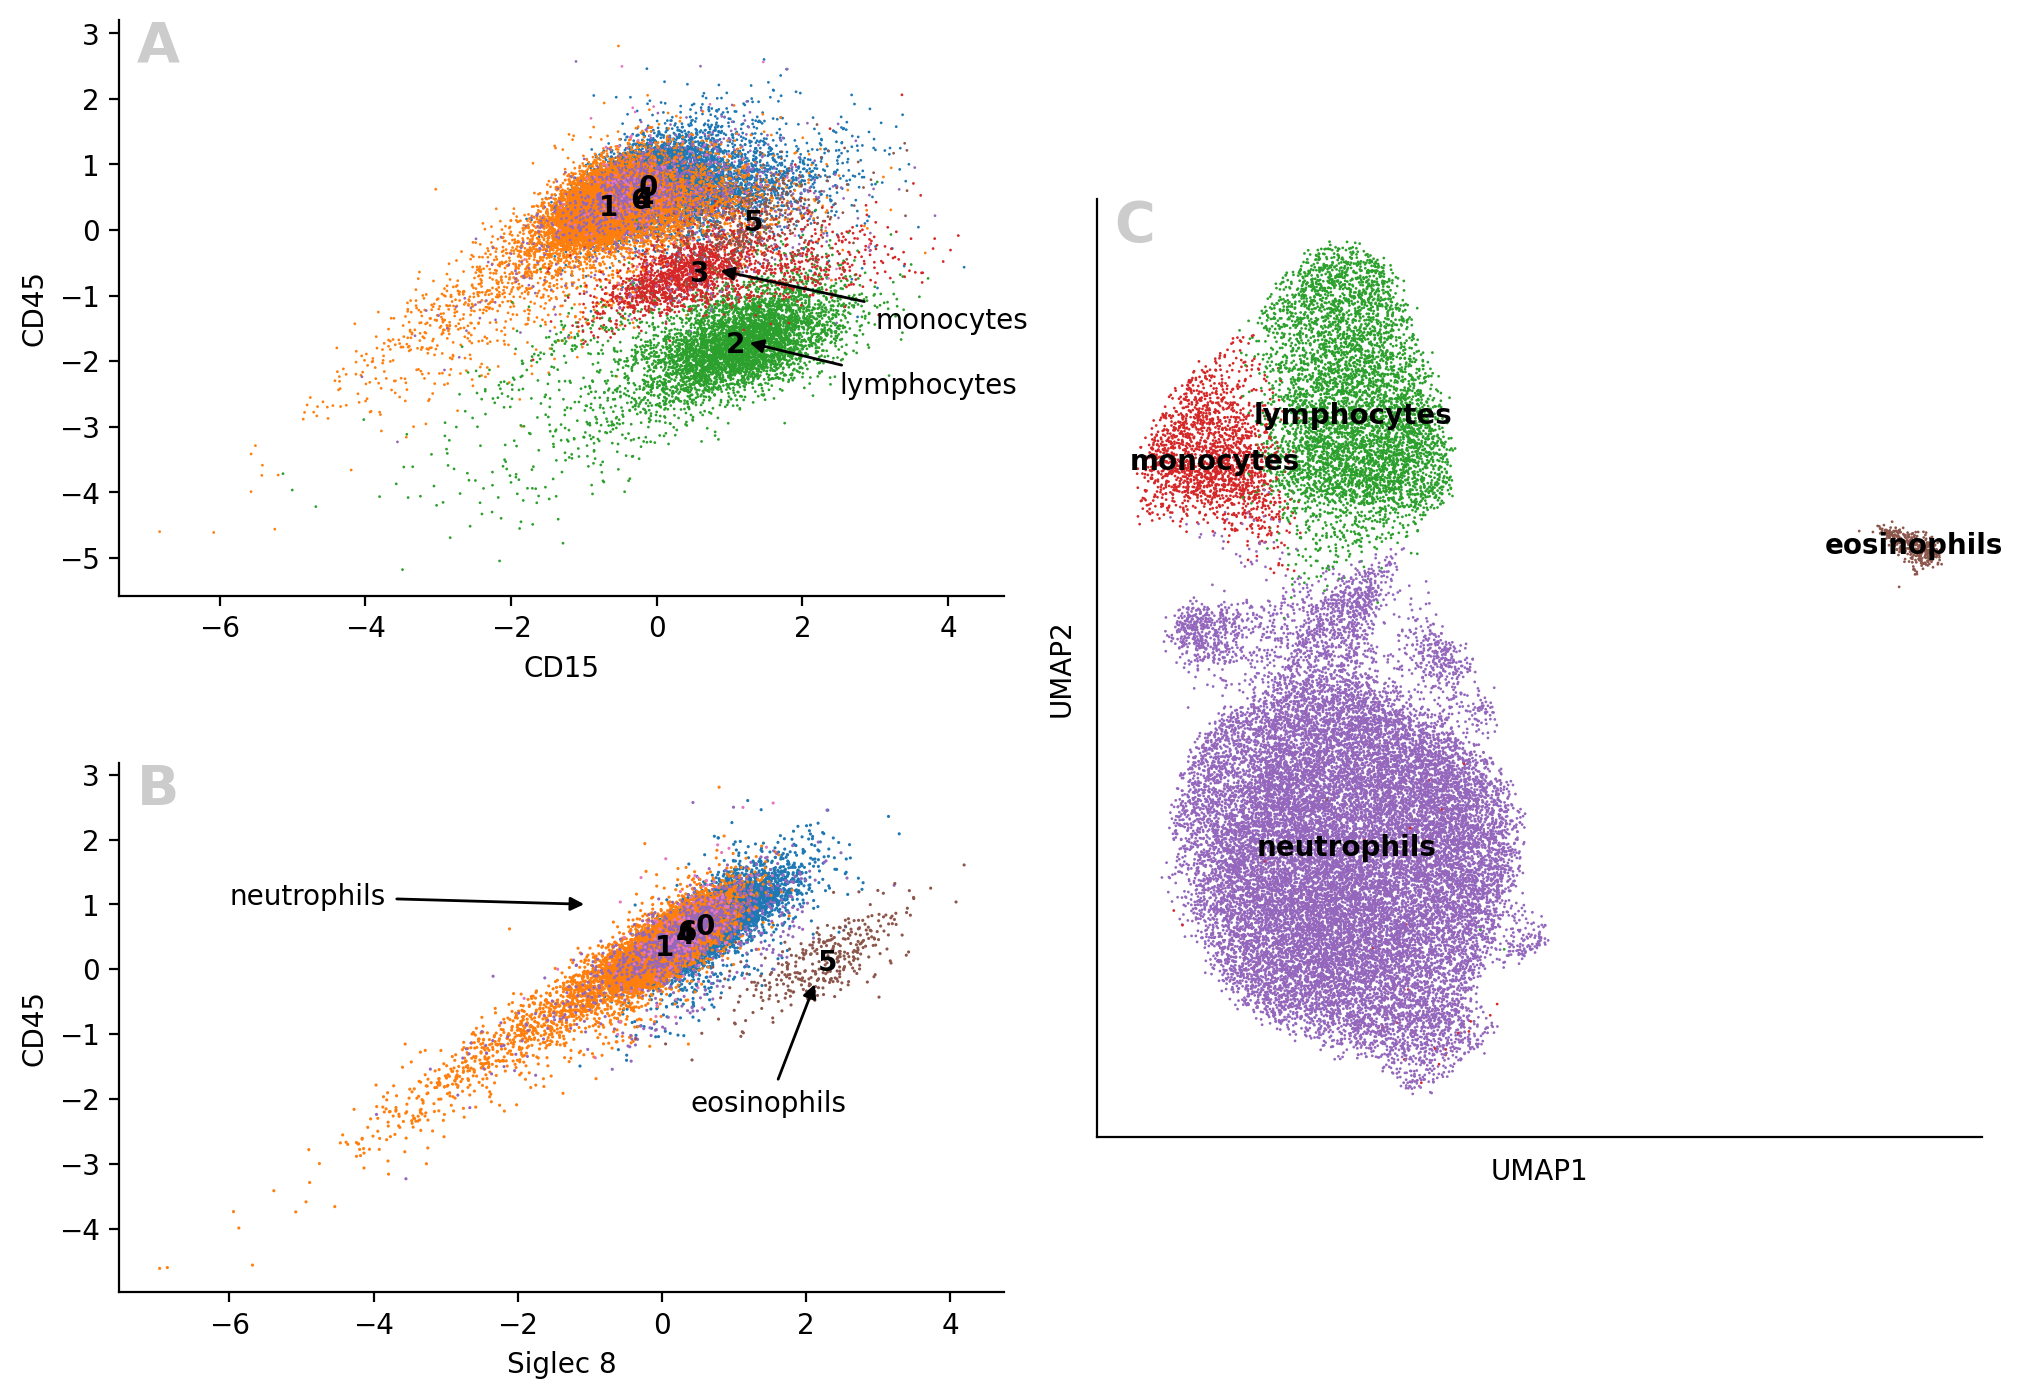

In [55]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(dpi=200, figsize=(10, 7), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
scanpy.pl.scatter(adata, x="feat_combined_sum_EGFP", y="feat_combined_sum_APC", color="leiden", legend_loc="on data", ax=ax, show=False)
ax.annotate('monocytes', xy=(.8, -.6), xytext=(3, -1.5), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax.annotate('lymphocytes', xy=(1.2, -1.7), xytext=(2.5, -2.5), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax.text(s="A", x=0.02, y=1, fontsize=20, weight="heavy", alpha=0.2, transform=ax.transAxes, va="top")
ax.set_xlabel("CD15")
ax.set_ylabel("CD45")
ax.set_title("")
ax.set_aspect(0.9)

# ax.annotate("", xytext=(2.5, 1.8), xy=(5, 2.5), arrowprops=dict(facecolor='grey', width=7, edgecolor="none", connectionstyle=ConnectionStyle("Arc3", rad=-0.2)))

ax2 = fig.add_subplot(gs[1, 0])
scanpy.pl.scatter(adata[adata.obs["cell type"].isin(['neutrophils', 'eosinophils'])], x="feat_combined_sum_RPe", y="feat_combined_sum_APC", color="leiden", legend_loc="on data", ax=ax2, show=False)
ax2.annotate('eosinophils', xy=(2.15, -.15), xytext=(.4, -2.2), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax2.annotate('neutrophils', xy=(-1, 1), xytext=(-6, 1), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax2.text(s="B", x=0.02, y=1, fontsize=20, weight="heavy", alpha=0.2, transform=ax2.transAxes, va="top")
ax2.set_title("")
ax2.set_ylabel("CD45")
ax2.set_xlabel("Siglec 8")
ax2.set_aspect(0.9)

ax3 = fig.add_subplot(gs[:, 1])
scanpy.pl.umap(adata, color=["cell type"], legend_loc='on data', ax=ax3, show=False, palette=plt.get_cmap("tab10")([5, 2, 3, 4]).tolist())
ax3.text(s="C", x=0.02, y=1, fontsize=20, weight="heavy", alpha=0.2, transform=ax3.transAxes, va="top")
ax3.set_title("")
ax3.set_aspect(1)

seaborn.despine(fig)

plt.savefig(output, bbox_inches='tight', pad_inches=0, dpi=200)

In [33]:
counts = adata.obs["cell type"].value_counts().to_frame()
counts["fraction"] = counts["cell type"] / counts["cell type"].sum()
counts.columns = ["Count", "Fraction"]
print(counts.style.to_latex())

\begin{tabular}{lrr}
 & Count & Fraction \\
neutrophils & 23237 & 0.754791 \\
lymphocytes & 5347 & 0.173683 \\
monocytes & 1867 & 0.060644 \\
eosinophils & 335 & 0.010882 \\
\end{tabular}



## Neutrophils

In [56]:
adata_neut = adata[adata.obs["cell type"] == "neutrophils"].copy()

In [60]:
discrete = ["median", "area", "euler"]
discrete_cols = [c for c in adata.var_names if any(d in c for d in discrete)]
discrete_cols_i = [i for i, c in enumerate(adata.var_names) if any(d in c for d in discrete)]

In [63]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    mi = mutual_info_classif(X=adata_neut.X, y=adata_neut.obs["leiden"], discrete_features=discrete_cols_i, n_neighbors=30, random_state=0)

CPU times: user 2min 1s, sys: 840 ms, total: 2min 2s
Wall time: 2min 2s


In [69]:
mi = pandas.Series(mi, index=adata_neut.var_names).sort_values(ascending=False)

<AxesSubplot:title={'center':'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

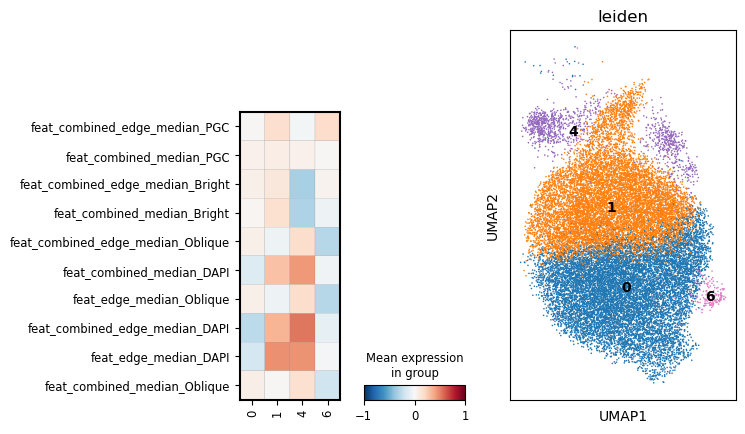

In [77]:
fig, axes = plt.subplots(1, 2)
ax = scanpy.pl.matrixplot(adata_neut, mi.index[:10], groupby='leiden', swap_axes=True, dendrogram=False, vmin=-1, vmax=1, cmap='RdBu_r', ax=axes[0], show=False)
scanpy.pl.umap(adata_neut, color="leiden", legend_loc='on data', ax=axes[1], show=False)

In [78]:
from scip_workflows.core import plot_gate_czi

0 P1-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P3-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P10-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P10-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P13-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P15-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P15-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P17-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P19-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi


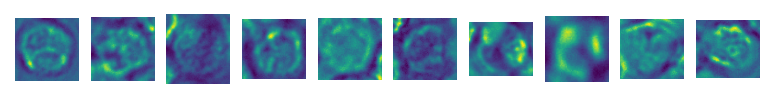

In [82]:
plot_gate_czi(
    sel=adata_neut.obs["leiden"] == '4',
    df=adata_neut.obs,
    channel=4,
    maxn=10
)

0 P3-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P8-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P8-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P12-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P17-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P22-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P23-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P25-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi


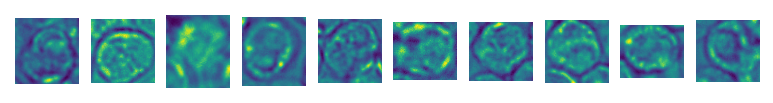

In [84]:
plot_gate_czi(
    sel=adata_neut.obs["leiden"] == '1',
    df=adata_neut.obs,
    channel=4,
    maxn=10
)

0 P4-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P5-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P6-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P7-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P8-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P10-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P16-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P18-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P20-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P23-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi


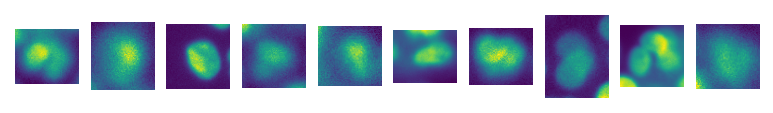

In [83]:
plot_gate_czi(
    sel=adata_neut.obs["leiden"] == '6',
    df=adata_neut.obs,
    channel=0,
    maxn=10
)

0 P5-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P9-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P10-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P10-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P11-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P16-D1 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P16-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P19-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P20-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi


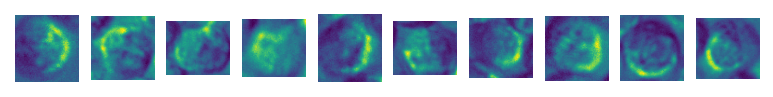

In [85]:
plot_gate_czi(
    sel=adata_neut.obs["leiden"] == '6',
    df=adata_neut.obs,
    channel=5,
    maxn=10
)

0 P2-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P4-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P5-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P9-D4 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P13-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P14-D5 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P17-D2 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P18-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi
0 P19-D3 /home/maximl/scratch/data/vsc/datasets/cd7/800/Experiment-800.czi


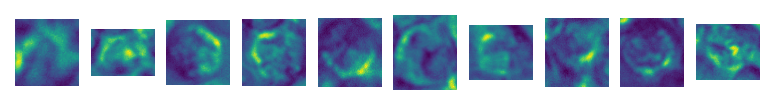

In [87]:
plot_gate_czi(
    sel=adata_neut.obs["leiden"] == '4',
    df=adata_neut.obs,
    channel=5,
    maxn=10
)